In [2]:
#import required libraries
import pandas as pd
import numpy as np
from scipy import stats
import re
from datetime import datetime, timedelta
import calendar
from collections import Counter, OrderedDict
import pickle
import json


#plotting
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

## Read CSV Files 
Dataset for 2004-2015

In [128]:
#specify the columns to use
cols_use = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt']

In [352]:
global tot_data

def read_csv_files(file_path, columns, year_range_end):
    list_of_dfs = []   

    for i in range(4,year_range_end):
        if(i<10):
            f_name = file_path[0:3]+str(i)+file_path[4:]
        else:
            f_name = file_path[0:2]+str(i)+file_path[4:]
        try:   
            if(i==4 or i==8 or i==12): #for the case of leap year
                temp_df = pd.read_csv(f_name, usecols=cols_use, skiprows=range(1417,1441))
                list_of_dfs.append(temp_df)
            else: #for the other years
                temp_df = pd.read_csv(f_name, usecols=cols_use)
                list_of_dfs.append(temp_df)
            print("Done. File Name: ", f_name, temp_df.shape)
        except Exception as e:
            print(e)
            
    return list_of_dfs


def append_dataframes(df_list):
    tot_data = df_list[0].append(df_list[1], ignore_index=True)

    for i in df_list[2:]:
        tot_data = tot_data.append(i, ignore_index=True)
    
    print(tot_data.shape)
    return tot_data


def load_files_rolling(name_file, year_range_end, new_preds=None):
    df_list = read_csv_files(name_file_one, cols_use, year_range_end)
    if(new_preds!=None):
        df_list[-2]['DA_DEMD'] = new_preds
    tot_data = append_dataframes(df_list)
    return tot_data
    


name_file_one = '2004.csv'

tot_data = load_files_rolling(name_file_one, 16, list(preds_dict[3]['Predicted']))

Done. File Name:  2004.csv (8760, 5)
Done. File Name:  2005.csv (8760, 5)
Done. File Name:  2006.csv (8760, 5)
Done. File Name:  2007.csv (8760, 5)
Done. File Name:  2008.csv (8760, 5)
Done. File Name:  2009.csv (8760, 5)
Done. File Name:  2010.csv (8760, 5)
Done. File Name:  2011.csv (8760, 5)
Done. File Name:  2012.csv (8760, 5)
Done. File Name:  2013.csv (8760, 5)
Done. File Name:  2014.csv (8760, 5)
Done. File Name:  2015.csv (8760, 5)
(105120, 5)


#### Get Features from dates

In [353]:
#convert the date string to datetime obj
def convert_string_to_datetime(string):
    datetime_obj = datetime.strptime(string, "%m/%d/%Y")
    return datetime_obj.date()

tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

#get weekday from date
def get_day_of_week(date_obj):
    return date_obj.weekday()

tot_data['Day'] = tot_data['Date'].apply(get_day_of_week)

def get_year(date_obj):
    return date_obj.year

def get_month(date_obj):
    return date_obj.month

tot_data['Year'] = tot_data['Date'].apply(get_year)
tot_data['Month'] = tot_data['Date'].apply(get_month)

#### Fill Missing Values

In [354]:
missing_vals = ['DA_DEMD']

for j in missing_vals:
    for i in range(len(tot_data[j])):
        if(tot_data[j][i] < 1):
            tot_data[j][i] = (tot_data[j][i-1]+tot_data[j][i+1])/2
    print(j)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


DA_DEMD


### Create Labels

#### Prepare Data for RNN

In [294]:
def concat_date_time_to_timestamp(df):
    #print(df['Date'], df['Hour'])
    return pd.Timestamp(df['Date'] + " "+ str(df['Hour']-1) + ":" + "00")

def give_rnn_data(data, date_train_string="31-12-2010", date_test_string="01-01-2011"):
    # data['Date'] = data[['Date', 'Hour']].apply(concat_date_time_to_timestamp, axis=1)
    tot_data_ts  = data[['Date', 'DA_DEMD', 'Hour', 'Year', 'Month', 'Day']]
    #tot_data_ts['Date'] = tot_data_ts['Date'].apply(convert_string_to_datetime)

    tot_data_ts = tot_data_ts.set_index(pd.DatetimeIndex(tot_data_ts['Date']))
    tot_data_ts = tot_data_ts.drop('Date', axis=1)

    for s in range(8761-24, 8761):
        tot_data_ts['DEMAND_shift_{}'.format(s)] = tot_data_ts['DA_DEMD'].shift(s)
        tot_data_ts['Hour_shift_{}'.format(s)] = tot_data_ts['Hour'].shift(s)
        tot_data_ts['Year_shift_{}'.format(s)] = tot_data_ts['Year'].shift(s)
        tot_data_ts['Month_shift_{}'.format(s)] = tot_data_ts['Month'].shift(s)
        tot_data_ts['Day_shift_{}'.format(s)] = tot_data_ts['Day'].shift(s)
        #tot_data_ts['DryB_shift_{}'.format(s)] = tot_data_ts['DryBulb'].shift(s)
        #print(s)
        
    tot_data_ts = tot_data_ts.drop(['Hour', 'Year', 'Month', 'Day'], axis=1)    
    X = tot_data_ts.dropna().drop('DA_DEMD', axis=1)
    Y = tot_data_ts.dropna()[['DA_DEMD']]

    train_x = X[:pd.Timestamp(date_train_string)]
    test_x = X[pd.Timestamp(date_test_string):]

    train_y = Y[:pd.Timestamp(date_train_string)]
    test_y = Y[pd.Timestamp(date_test_string):]
    
    train_x = train_x.values
    test_x = test_x.values

    train_y = train_y.values
    test_y = test_y.values
    
    from sklearn import preprocessing
    std_scaler2 = preprocessing.StandardScaler()
    train_x_scaled = std_scaler2.fit_transform(train_x)
    test_x_scaled = std_scaler2.fit_transform(test_x)
    train_y_scaled = std_scaler2.fit_transform(train_y)
    
    return(train_x_scaled, test_x_scaled, train_y_scaled, test_y, std_scaler2)

### Deal With Missing DEMAND and LMP  values

## Feature Engineering

#### Break Down Date into Further Features

##### Get Daily Mean Values of DEMAND, LMP, Temp and Dew Pnt

##### Get Daily Max and Min Values of Temp and Dew Pnt

##### Add Crude Oil and Natural Gas Data

## Feature Selection and Scaling

Create Separate Data sets for **Load** and **Price**

In [45]:
tot_data.columns

Index(['Date', 'Hour', 'DA_DEMD_', 'DryBulb___', 'DewPnt___', 'TARGET_DA_DEMD',
       'Day', 'Year', 'Month', 'DA_DEMD_daily_mean', 'DryBulb_daily_mean',
       'DewPnt_daily_mean', 'DryBulb__daily_max', 'DewPnt__daily_max',
       'DryBulb___daily_min', 'DewPnt___daily_min'],
      dtype='object')

##### Demand Prediction Dataset

# Model Building

#### Metrics

In [2]:
#metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#function to calculate mape
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def point_absolute_percentage_error(y_pred, y_true):
    return np.abs((y_true - y_pred) / y_true) * 100

#GIVE Everything you can imagine of function - SD, VAR, MIN and MAX ERROR, CI
def get_CI_VAR_SD(error_list):
    t = stats.t.ppf(1-0.025, len(error_list)-1)
    max_err = np.mean(error_list) + (t * (np.std(error_list)/np.sqrt(len(error_list))))
    min_err = np.mean(error_list) - (t * (np.std(error_list)/np.sqrt(len(error_list))))
    ci = ((max_err - np.mean(error_list))/np.mean(error_list))*100
    sd = np.std(error_list)
    var = np.var(error_list)
    return (max_err, min_err, ci, sd, var)


def get_scoring(model, test_file, train_file, load_test_y, load_train_y, scaler, load=True, metric='mape', 
                keras_nn=False):
    train_preds = model.predict(train_file)
    if(keras_nn):
        train_preds = train_preds.flatten()
    train_preds = scaler.inverse_transform(train_preds)
    
    test_preds = model.predict(test_file)
    if(keras_nn):
        test_preds = test_preds.flatten()
    test_preds = scaler.inverse_transform(test_preds)
    
    if(load):
        if(metric == 'mape'):
            err_train = mean_absolute_percentage_error(train_preds, load_train_y)
            err_test = mean_absolute_percentage_error(test_preds, load_test_y)
    
        if(metric == 'mae'):
            err_train = mean_absolute_error(train_preds, load_train_y)
            err_test = mean_absolute_error(test_preds, load_test_y)
            
        if(metric == 'rmse'):
            err_train = np.sqrt(mean_squared_error(train_preds, load_train_y))
            err_test = np.sqrt(mean_squared_error(test_preds, load_test_y))
            
    return(err_test, test_preds, err_train, train_preds)



def get_monthly_scores(test_preds, test_y, metric='mape'):
    days_list = [0,31,28,31,30,31,30,31,31,30,31,30,31]
    score_dict = OrderedDict()
    
    for i in range(0,len(days_list)-1):
        mnth = calendar.month_abbr[i+1]
        if(metric=='mape'):
            score_dict[mnth] = mean_absolute_percentage_error(
                            test_preds[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])
    return score_dict  

##### Load Models

In [61]:
#NN Models
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.models import model_from_json

Using TensorFlow backend.


In [160]:
#Other Models 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.grid_search import GridSearchCV

##### Save Model to Disk

In [187]:
def save_model(model_obj, filename):
    try:
        with open(filename, 'wb') as fid:
            pickle.dump(model_obj, fid) 
        print("Done")
    except Exception as e: print(e)
        
        
def save_keras_model_to_json(model, filename):
    try:
        json_arch = model.to_json()
        with open(filename, 'w') as outfile:
            json.dump(json_arch, outfile)
        print("Done")
    except Exception as e: print(e)
    '''
    model reconstruction from JSON:
    model = model_from_json(json_string)
    '''
    
def read_keras_model_from_json(filename):
    file = open(filename, 'r')
    model_json_str = file.read()
    file.close()
    model = model_from_json(model_json_str)
    return model_json_str

### Demand Prediction

### LSTM

In [ ]:
preds_dict = {}

#### if time series dataset

In [346]:
load_train_x_scaled, load_test_x_scaled, load_train_y_scaled, load_test_y, scaler = give_rnn_data(tot_data,
                                                                                    date_train_string="31-12-2014", 
                                                                                    date_test_string="01-01-2015")
load_rnn_train_x = load_train_x_scaled.reshape(load_train_x_scaled.shape[0],24,5)
load_rnn_test_x = load_test_x_scaled.reshape(load_test_x_scaled.shape[0],24,5)

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

print(load_rnn_train_x.shape)

(78840, 24, 5)


In [355]:
K.clear_session()
lstm_model = Sequential()

lstm_model.add(LSTM(15, input_shape=(24, 5), activation='relu', return_sequences=True))
lstm_model.add(LSTM(15, activation='relu', return_sequences=True))
lstm_model.add(LSTM(15, activation='relu'))
lstm_model.add(Dense(1))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lstm_model.compile(loss='mean_absolute_error', optimizer=sgd)

lstm_model.fit(load_rnn_train_x, load_train_y_scaled,
          epochs=15, batch_size=300, verbose=1,
         callbacks=[early_stop], validation_split=0.1)

Train on 70956 samples, validate on 7884 samples
Epoch 1/15
70956/70956 [==============================] - 23s - loss: 0.6232 - val_loss: 0.3815
Epoch 2/15
70956/70956 [==============================] - 23s - loss: 0.4254 - val_loss: 0.3079
Epoch 3/15
70956/70956 [==============================] - 23s - loss: 0.3934 - val_loss: 0.3723
Epoch 4/15
70956/70956 [==============================] - 23s - loss: 0.3797 - val_loss: 0.2728
Epoch 5/15
70956/70956 [==============================] - 23s - loss: 0.3704 - val_loss: 0.2594
Epoch 6/15
70956/70956 [==============================] - 23s - loss: 0.3626 - val_loss: 0.3008
Epoch 7/15
70956/70956 [==============================] - 23s - loss: 0.3559 - val_loss: 0.2811
Epoch 8/15
70956/70956 [==============================] - 23s - loss: 0.3501 - val_loss: 0.3631
Epoch 9/15
70956/70956 [==============================] - 23s - loss: 0.3456 - val_loss: 0.2854
Epoch 10/15
70956/70956 [==============================] - 23s - loss: 0.3414 - val_los

In [357]:
load_train_y = scaler.inverse_transform(load_train_y_scaled).flatten()
load_test_y = load_test_y.flatten()
lstm_test_err, lstm_test_preds, lstm_train_err, lstm_train_preds = get_scoring(lstm_model, load_rnn_test_x, 
                                                                            load_rnn_train_x, load_test_y,
                                                                            load_train_y, scaler, 
                                                                            True, 'mape', True)

year_preds = {}
year_preds['Monthly'] = get_monthly_scores(lstm_test_preds, load_test_y)
year_preds['True'] = load_test_y
year_preds['Predicted'] = lstm_test_preds
year_preds['MAPE_TEST'] = lstm_test_err

preds_dict[4] = year_preds

print(lstm_test_err, lstm_train_err)

6.17074721995 6.31979676838


In [358]:
preds_dict

{0: {'MAPE_TEST': 5.6745484979367138,
  'Monthly': OrderedDict([('Jan', 4.4433376066517196),
               ('Feb', 4.7181539480468642),
               ('Mar', 3.6550199703579929),
               ('Apr', 3.3681999472502278),
               ('May', 6.1164359703830744),
               ('Jun', 8.1734358214132712),
               ('Jul', 7.9288527469573422),
               ('Aug', 7.4751783318638605),
               ('Sep', 6.2738973030747465),
               ('Oct', 3.7936318206324691),
               ('Nov', 4.1492572002530981),
               ('Dec', 7.8829688125679906)]),
  'Predicted': array([  12535.81347656,   12407.89453125,   12277.51660156, ...,
         -105290.203125  ,  -57701.125     ,    6507.78125   ], dtype=float32),
  'True': array([ 11722.,  11253.,  10459., ...,  13911.,  13100.,  12410.])},
 1: {'MAPE_TEST': 7.5262240200096659,
  'Monthly': OrderedDict([('Jan', 7.3440107886973749),
               ('Feb', 6.7625252646350846),
               ('Mar', 8.7268818822904777),


In [375]:
output = open('output.txt', 'ab+')

pickle.dump(preds_dict, output)
output.close()

### RESULTS
Metrics Calculation

In [3]:
output = open('output.txt', 'rb')
obj_dict = pickle.load(output)  

In [5]:
obj_dict

{0: {'MAPE_TEST': 5.6745484979367138,
  'Monthly': OrderedDict([('Jan', 4.4433376066517196),
               ('Feb', 4.7181539480468642),
               ('Mar', 3.6550199703579929),
               ('Apr', 3.3681999472502278),
               ('May', 6.1164359703830744),
               ('Jun', 8.1734358214132712),
               ('Jul', 7.9288527469573422),
               ('Aug', 7.4751783318638605),
               ('Sep', 6.2738973030747465),
               ('Oct', 3.7936318206324691),
               ('Nov', 4.1492572002530981),
               ('Dec', 7.8829688125679906)]),
  'Predicted': array([  12535.81347656,   12407.89453125,   12277.51660156, ...,
         -105290.203125  ,  -57701.125     ,    6507.78125   ], dtype=float32),
  'True': array([ 11722.,  11253.,  10459., ...,  13911.,  13100.,  12410.])},
 1: {'MAPE_TEST': 7.5262240200096659,
  'Monthly': OrderedDict([('Jan', 7.3440107886973749),
               ('Feb', 6.7625252646350846),
               ('Mar', 8.7268818822904777),


In [6]:
point_err_yr1 = point_absolute_percentage_error(obj_dict[0]['Predicted'], obj_dict[0]['True'])
max_err_yr1, min_err_yr1, ci_yr1, sd_yr1, var_yr1 = get_CI_VAR_SD(point_err_yr1)
print(max_err_yr1, min_err_yr1, ci_yr1, sd_yr1, var_yr1)

5.94774914172 5.40134785415 4.81449130067 13.044446724 170.157590337


In [9]:
point_err_yr2 = point_absolute_percentage_error(obj_dict[1]['Predicted'], obj_dict[1]['True'])
max_err_yr2, min_err_yr2, ci_yr2, sd_yr2, var_yr2 = get_CI_VAR_SD(point_err_yr2)
print(max_err_yr2, min_err_yr2, ci_yr2, sd_yr2, var_yr2)

7.64789417816 7.40455386186 1.61661621855 5.80935635412 33.7486212491


In [11]:
point_err_yr3 = point_absolute_percentage_error(obj_dict[2]['Predicted'], obj_dict[2]['True'])
max_err_yr3, min_err_yr3, ci_yr3, sd_yr3, var_yr3 = get_CI_VAR_SD(point_err_yr3)
print(max_err_yr3, min_err_yr3, ci_yr3, sd_yr3, var_yr3)

7.11904254286 6.26853415161 6.35296746132 20.304511813 412.273199966


In [12]:
point_err_yr4 = point_absolute_percentage_error(obj_dict[3]['Predicted'], obj_dict[3]['True'])
max_err_yr4, min_err_yr4, ci_yr4, sd_yr4, var_yr4 = get_CI_VAR_SD(point_err_yr4)
print(max_err_yr4, min_err_yr4, ci_yr4, sd_yr4, var_yr4)

7.00426318084 6.31219309358 5.19710404176 16.5220536406 272.978256503


In [13]:
point_err_yr5 = point_absolute_percentage_error(obj_dict[4]['Predicted'], obj_dict[4]['True'])
max_err_yr5, min_err_yr5, ci_yr5, sd_yr5, var_yr5 = get_CI_VAR_SD(point_err_yr5)
print(max_err_yr5, min_err_yr5, ci_yr5, sd_yr5, var_yr5)

6.5647689231 5.77672551681 6.38531589614 18.8132613584 353.93880294


In [16]:
total_predicted = list(obj_dict[0]['Predicted'])+list(obj_dict[1]['Predicted'])
total_test_true = list(obj_dict[0]['True'])+list(obj_dict[1]['True'])
for i in range(2,5):
    total_predicted = total_predicted + list(obj_dict[i]['Predicted'])
    total_test_true = total_test_true + list(obj_dict[i]['True'])

In [18]:
point_err_tot = point_absolute_percentage_error(np.array(total_predicted), np.array(total_test_true))
max_err_tot, min_err_tot, ci_tot, sd_tot, var_tot = get_CI_VAR_SD(point_err_tot)
print(max_err_tot, min_err_tot, ci_tot, sd_tot, var_tot)

6.69248916707 6.39692532187 2.25803717537 15.7796830176 248.998396137


In [19]:
mean_absolute_percentage_error(np.array(total_predicted), np.array(total_test_true))

6.5447072444690502

### MLP

### XGBoost

# Plots

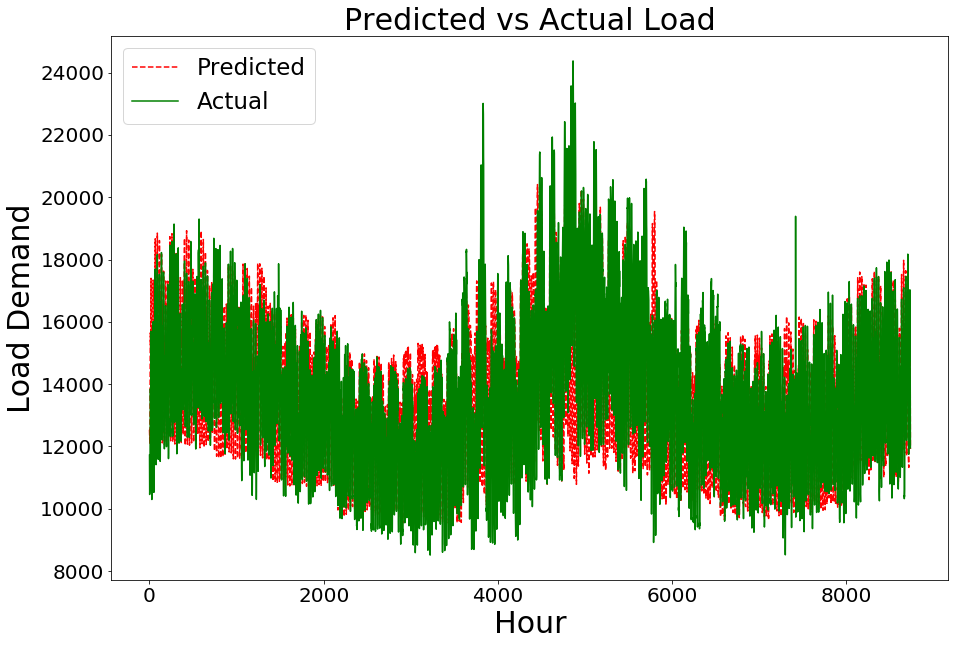

In [421]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':preds_dict[0]['Predicted'][:-24], 
    'Actual':preds_dict[0]['True'][:-24]   
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Predicted")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Load", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
#plt.show()
#plt.gcf()
plt.savefig("plot_single_year_1st_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

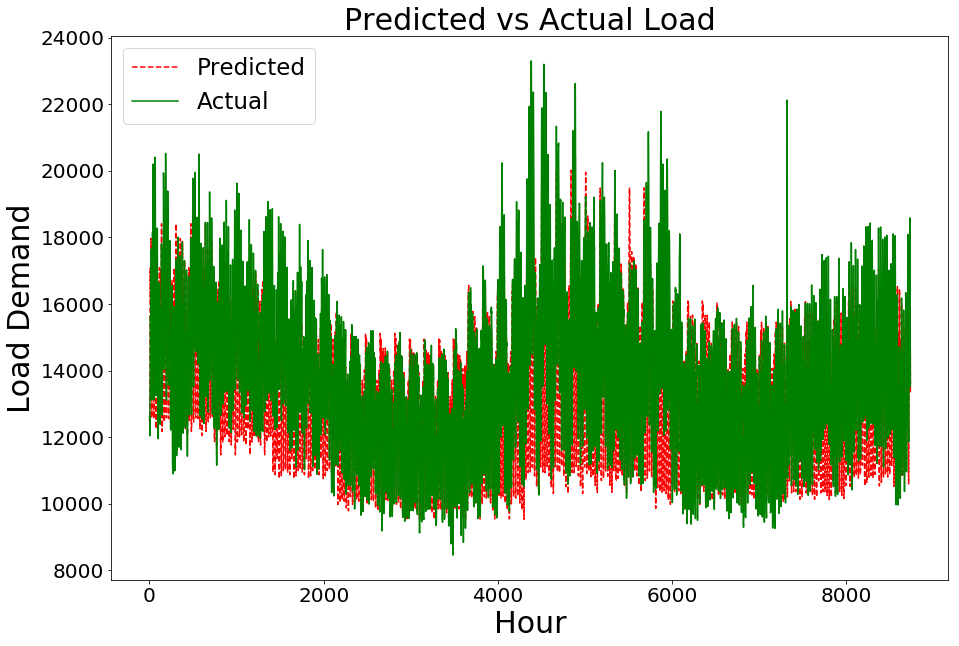

In [422]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':preds_dict[4]['Predicted'][:-24], 
    'Actual':preds_dict[4]['True'][:-24]   
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Predicted")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Load", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
#plt.show()
#plt.gcf()
plt.savefig("plot_single_year_5th_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

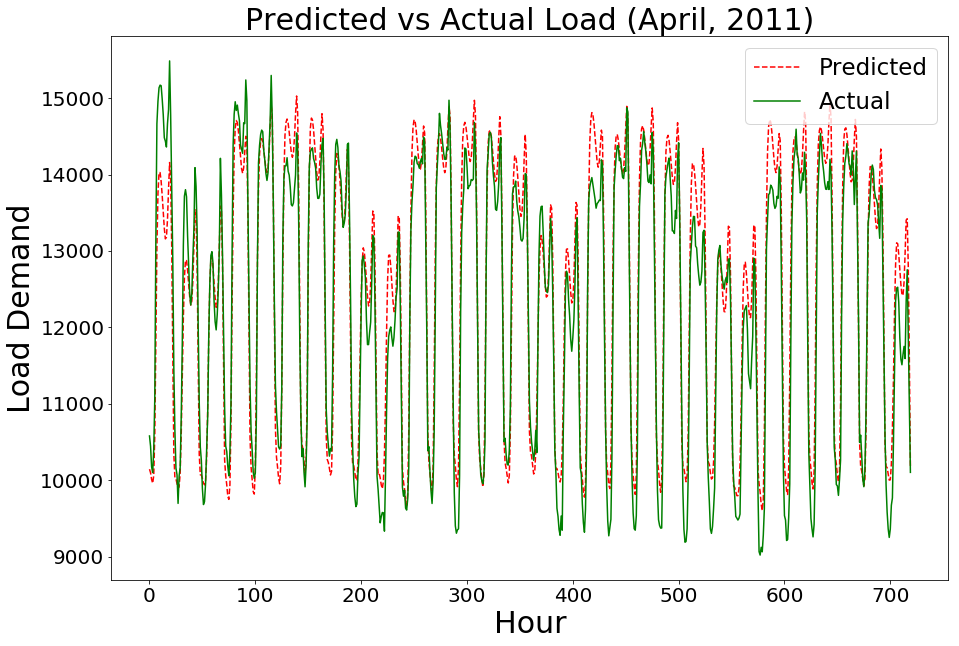

In [423]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':preds_dict[0]['Predicted'][2160:2880], 
    'Actual':preds_dict[0]['True'][2160:2880]   
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Predicted")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Load (April, 2011)", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
#plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1, fontsize=18)
#plt.show()
#plt.gcf()
plt.savefig("plot_single_month_1st_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

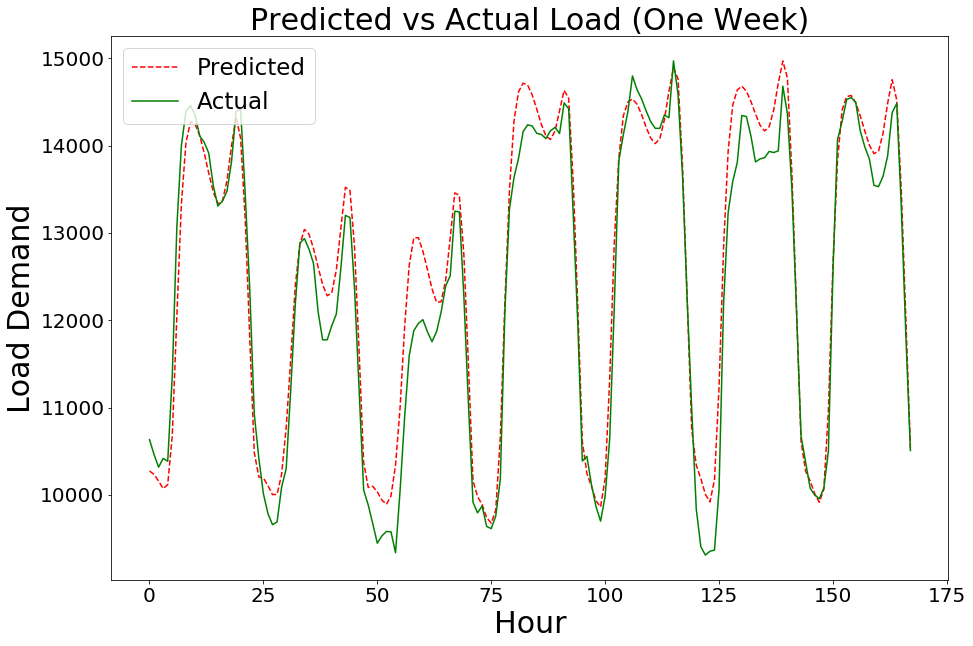

In [424]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':preds_dict[0]['Predicted'][2160+168:2160+168+168], 
    'Actual':preds_dict[0]['True'][2160+168:2160+168+168]   
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Predicted")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Load (One Week)", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
#plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1, fontsize=18)
#plt.show()
#plt.gcf()
plt.savefig("plot_single_week_1st_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

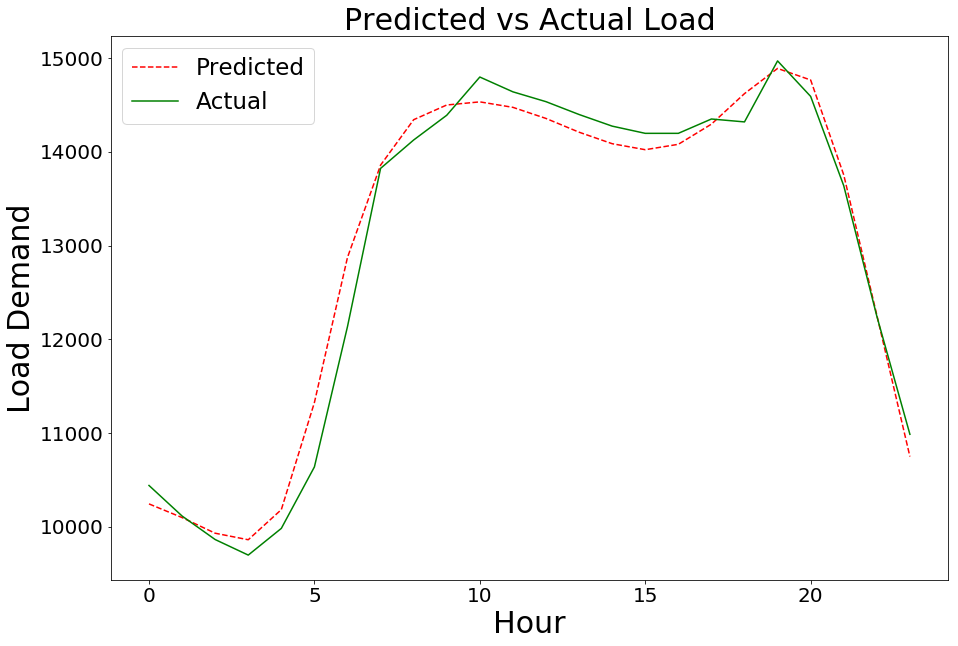

In [4]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'Proposed':obj_dict[0]['Predicted'][2160+168+48+24+24:2160+168+48+24+24+24], 
    'Actual':obj_dict[0]['True'][2160+168+48+24+24:2160+168+48+24+24+24]   
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'r--', label="Predicted")
plt.plot(temp['Actual'], 'g-', label="Actual")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Load", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
#plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1, fontsize=18)
#plt.show()
#plt.gcf()
plt.savefig("plot_single_day_1st_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

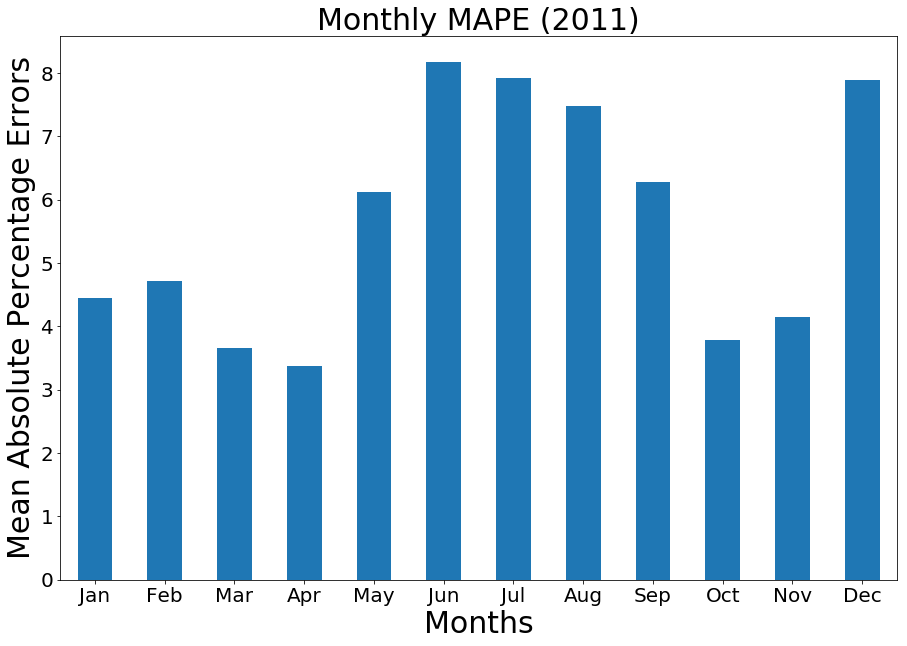

In [418]:
abcdef = pd.DataFrame([j for i,j in preds_dict[0]['Monthly'].items()])
abcdef = abcdef.transpose()
my_plt = abcdef.mean().plot(kind='bar')
plt.xlabel("Months", {'fontsize':30})
plt.ylabel("Mean Absolute Percentage Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
my_plt.set_xticklabels([i for i,j in preds_dict[0]['Monthly'].items()])
plt.title("Monthly MAPE (2011)", {'fontsize':30})
plt.savefig("plot_monthly_mape_1st_year.jpg", format='jpg', bbox_inches='tight', dpi=600)

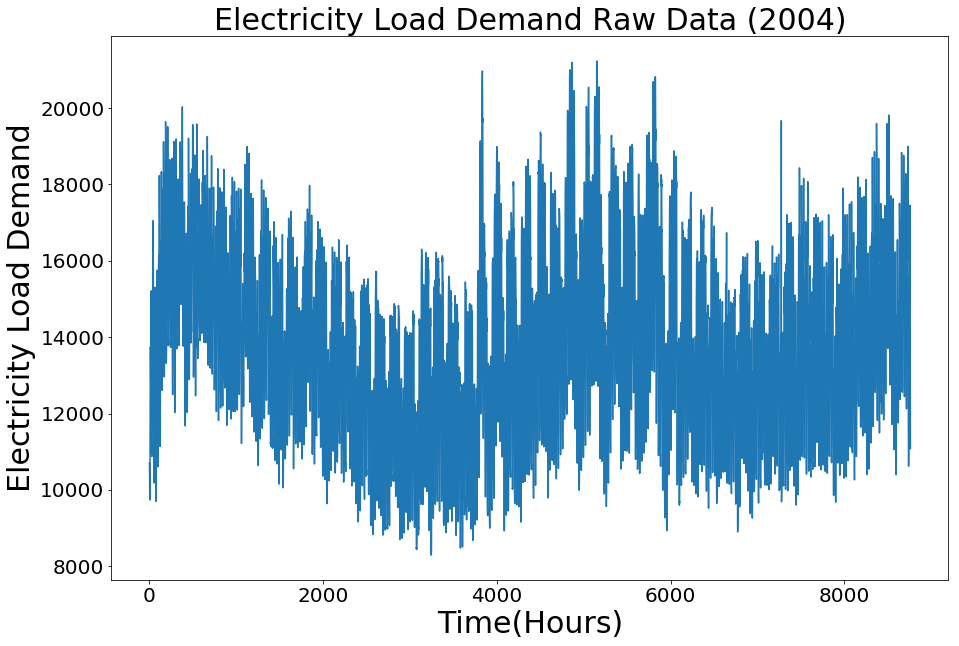

In [425]:
plt.plot(tot_data['DA_DEMD'][:8760])
plt.xlabel("Time(Hours)", {'fontsize':30})
plt.ylabel("Electricity Load Demand",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Electricity Load Demand Raw Data (2004)", {'fontsize':30})
plt.savefig("plot_electricity_demands.jpg", format='jpg', bbox_inches='tight', dpi=600)

In [427]:
!nvidia-smi

Tue Nov  7 22:31:20 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:1E.0     Off |                    0 |
| N/A   45C    P0    81W / 149W |  10913MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  